# Sistema de Recomendación de Películas

Este notebook crea un sistema de recomendación que sugiere películas del Top 250 de IMDB basado en:
- Tus ratings de Letterboxd
- Rating en IMDB
- Año de la película
- Géneros
- Actores involucrados
- Directores

## 1. Configuración Inicial
Primero, instalamos e importamos las librerías necesarias.

In [ ]:
# Instalación de paquetes (ejecutar solo una vez)
!pip install imdbpy scikit-learn pandas numpy matplotlib seaborn

In [1]:
# Importaciones
import pandas as pd
import numpy as np
from imdb import IMDb
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

# Configuración
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
ia = IMDb()

## 2. Carga de Datos

Cargamos tus ratings de Letterboxd y el Top 250 de IMDB.

**Nota**: Asumo que tienes estos archivos CSV. Si no, puedes cargar los datos directamente desde IMDB.

In [2]:
def cargar_datos():
    """Carga y prepara los datasets"""
    # Cargar tus ratings de Letterboxd (ajusta los nombres de columnas)
    letterboxd = pd.read_csv('letterboxd_ratings.csv')
    letterboxd = letterboxd.rename(columns={
        'Name': 'title',
        'Year': 'year',
        'Rating': 'rating'
    })

    # Cargar Top 250 de IMDB (puedes generarlo con imdbpy si no tienes el CSV)
    imdb_top = pd.read_csv('imdb_top250.csv')
    imdb_top = imdb_top.rename(columns={
        'name': 'title',
        'year': 'year',
        'rating': 'imdb_rating'
    })

    return letterboxd, imdb_top

In [3]:
letterboxd_ratings, imdb_top250 = cargar_datos()

# Mostrar datos
print("Tus ratings:")
display(letterboxd_ratings.head(2))
print("\nTop 250 de IMDB:")
display(imdb_top250.head(2))

Tus ratings:


,Date,title,year,Letterboxd URI,rating
0,2025-01-19,The Godfather,1972,https://boxd.it/2aNK,5.0
1,2025-01-19,Good Will Hunting,1997,https://boxd.it/2ahY,5.0



Top 250 de IMDB:


,rank,title,year,imdb_rating,genre,certificate,run_time,tagline,budget,box_office,casts,directors,writers
0,1,The Shawshank Redemption,1994,9.3,Drama,R,2h 22m,Fear can hold you prisoner. Hope can set you f...,25000000,28884504,"Tim Robbins,Morgan Freeman,Bob Gunton,William ...",Frank Darabont,"Stephen King,Frank Darabont"
1,2,The Godfather,1972,9.2,"Crime,Drama",R,2h 55m,An offer you can't refuse.,6000000,250341816,"Marlon Brando,Al Pacino,James Caan,Diane Keato...",Francis Ford Coppola,"Mario Puzo,Francis Ford Coppola"


## 3. Enriquecimiento de Datos

Vamos a obtener información adicional de IMDB para tus películas calificadas.

In [4]:
def obtener_info_imdb(title, year):
    """Obtiene datos de IMDB con manejo de errores y caché"""
    try:
        resultados = ia.search_movie(f"{title} {year}")
        if not resultados:
            return None

        pelicula = ia.get_movie(resultados[0].movieID)

        return {
            'title': pelicula.get('title', title),
            'year': pelicula.get('year', year),
            'imdb_rating': pelicula.get('rating', np.nan),
            'genres': pelicula.get('genres', []),
            'directors': [d['name'] for d in pelicula.get('directors', [])],
            'actors': [a['name'] for a in pelicula.get('actors', [])[:3]],
            'runtime': pelicula.get('runtime', [0])[0] if pelicula.get('runtime') else 0
        }
    except Exception:
        return None

In [5]:
def enriquecer_fila(fila, es_letterboxd):
    """Enriquece una fila con datos de IMDb"""
    info = obtener_info_imdb(str(fila['title']), fila['year'])
    if info and es_letterboxd:
        info['user_rating'] = fila['rating']
    return info

### Ahora se eligió usar el ThreadPoolExecutor, el cual acelera significativamente el proceso de enriquecimiento de datos

In [6]:
def enriquecer_datos(df, es_letterboxd=True, max_workers=10):
    """Añade datos de IMDB a un DataFrame usando concurrencia"""
    datos_enriquecidos = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futuros = {executor.submit(enriquecer_fila, fila, es_letterboxd): fila for _, fila in df.iterrows()}
        for futuro in tqdm(as_completed(futuros), total=len(futuros)):
            resultado = futuro.result()
            if resultado:
                datos_enriquecidos.append(resultado)
    return pd.DataFrame(datos_enriquecidos)

In [7]:
# Enriquecer datos
print("\nEnriqueciendo tus ratings de Letterboxd...")
letterboxd_enriched = enriquecer_datos(letterboxd_ratings)

print("\nEnriqueciendo Top 250 de IMDB...")
imdb_enriched = enriquecer_datos(imdb_top250, es_letterboxd=False)

# Mostrar resultados
print(f"\nPelículas enriquecidas: {len(letterboxd_enriched)}/{len(letterboxd_ratings)}")
display(letterboxd_enriched.head(2))


Enriqueciendo tus ratings de Letterboxd...


100%|██████████| 269/269 [03:03<00:00,  1.47it/s]



Enriqueciendo Top 250 de IMDB...


100%|██████████| 250/250 [02:49<00:00,  1.48it/s]


Películas enriquecidas: 269/269


,title,year,imdb_rating,genres,directors,actors,runtime,user_rating
0,Cars 3,2017,6.7,"[Animation, Adventure, Comedy, Family, Sport]",[Brian Fee],"[Owen Wilson, Cristela Alonzo, Chris Cooper]",102,1.0
1,Bolt,2008,6.8,"[Animation, Adventure, Comedy, Crime, Drama, F...","[Byron Howard, Chris Williams]","[John Travolta, Miley Cyrus, Susie Essman]",96,5.0


In [8]:
letterboxd_enriched.to_csv("letterboxd_enriched.csv", index=False)
imdb_enriched.to_csv("imdb_enriched.csv", index=False)

In [9]:
letterboxd_enriched = pd.read_csv("letterboxd_enriched.csv")
imdb_enriched = pd.read_csv("imdb_enriched.csv")

## 4. Preprocesamiento de Datos

In [10]:
# Combinar los datos para el modelo
all_movies = pd.concat([letterboxd_enriched, imdb_enriched]).drop_duplicates(['title', 'year'])

In [11]:
# Convertir géneros, directores y actores en características binarias
genres_mlb = MultiLabelBinarizer()
genres_encoded = genres_mlb.fit_transform(all_movies['genres'])

directors_mlb = MultiLabelBinarizer()
directors_encoded = directors_mlb.fit_transform(all_movies['directors'])

actors_mlb = MultiLabelBinarizer()
actors_encoded = actors_mlb.fit_transform(all_movies['actors'])


In [12]:
# Escalar características numéricas
scaler = MinMaxScaler()
numerical_features = scaler.fit_transform(all_movies[['year', 'imdb_rating', 'user_rating']].fillna(0))

## 5. Modelado y Recomendación

In [13]:
# Combinar todas las características
all_features = np.hstack([
    numerical_features,
    genres_encoded,
    directors_encoded,
    actors_encoded
])

In [14]:
# Entrenar modelo de vecinos más cercanos
model = NearestNeighbors(n_neighbors=10, metric='cosine')
model.fit(all_features[:len(letterboxd_enriched)])  # Solo entrenar con tus películas calificadas

NearestNeighbors(metric='cosine', n_neighbors=10)

In [15]:
import ast

def safe_literal_eval(s):
    """Convierte strings como "['Action', 'Drama']" en listas reales."""
    try:
        return ast.literal_eval(s) if isinstance(s, str) else s
    except (ValueError, SyntaxError):
        return []  # Si falla, devuelve lista vacía

# Aplicar a las columnas relevantes
letterboxd_enriched['genres'] = letterboxd_enriched['genres'].apply(safe_literal_eval)
letterboxd_enriched['directors'] = letterboxd_enriched['directors'].apply(safe_literal_eval)
letterboxd_enriched['actors'] = letterboxd_enriched['actors'].apply(safe_literal_eval)
imdb_enriched['genres'] = imdb_enriched['genres'].apply(safe_literal_eval)
imdb_enriched['directors'] = imdb_enriched['directors'].apply(safe_literal_eval)
imdb_enriched['actors'] = imdb_enriched['actors'].apply(safe_literal_eval)

In [16]:
def extract_user_preferences(user_ratings_df):
    """Analiza géneros, directores y años más frecuentes, ignorando valores vacíos o inválidos."""
    # Géneros más comunes (excluyendo strings vacíos o caracteres sueltos)
    genres_flat = [g for genres in user_ratings_df['genres'] for g in genres if isinstance(g, str) and len(g) > 1]
    top_genres = pd.Series(genres_flat).value_counts().index[:3].tolist()

    # Directores más comunes (mismo filtro)
    directors_flat = [d for directors in user_ratings_df['directors'] for d in directors if isinstance(d, str) and len(d) > 1]
    top_directors = pd.Series(directors_flat).value_counts().index[:2].tolist()

    # Directores más comunes (mismo filtro)
    actors_flat = [a for actors in user_ratings_df['actors'] for a in actors if isinstance(a, str) and len(a) > 1]
    top_actors = pd.Series(actors_flat).value_counts().index[:2].tolist()

    preferences = {
        'genres': top_genres if top_genres else ['Drama'],  # Valor por defecto si no hay datos
        'directors': top_directors if top_directors else [],
        'actors': top_actors if top_actors else [],
        'avg_rating': float(user_ratings_df['user_rating'].mean())
    }
    return preferences
user_prefs = extract_user_preferences(letterboxd_enriched)

In [17]:
# 1. Primero, crea el conjunto de películas calificadas
rated_movies = set(
    f"{row['title'].lower().strip()} ({int(row['year'])})"
    for _, row in letterboxd_enriched.iterrows()
)

def recommend_based_on_genres_and_directors(top250_df, user_prefs, rated_movies, n_recommendations=10):
    """
    Recomienda películas del Top 250 que NO estén en tus ratings,
    basado solo en géneros y directores.
    """
    # Filtrar películas no calificadas
    top250_unrated = top250_df[
        ~top250_df.apply(
            lambda row: f"{row['title'].lower().strip()} ({int(row['year'])})" in rated_movies,
            axis=1
        )
    ].copy()

    # Si no hay suficientes películas, relajar el filtro (opcional)
    if len(top250_unrated) < n_recommendations:
        top250_unrated = top250_df.copy()
        print("⚠️ Advertencia: No hay suficientes películas no calificadas. Mostrando algunas del Top 250 igualmente.")

    # Puntuación por géneros y directores (como antes)
    top250_unrated['genre_score'] = top250_unrated['genres'].apply(
        lambda x: sum(1 for g in x if g in user_prefs['genres'])
    )
    top250_unrated['director_score'] = top250_unrated['directors'].apply(
        lambda x: 2 if any(d in x for d in user_prefs['directors']) else 0
    )
    top250_unrated['actor_score'] = top250_unrated['actors'].apply(
        lambda x: 2 if any(a in x for a in user_prefs['actors']) else 0
    )
    top250_unrated['similarity_score'] = (
        top250_unrated['genre_score'] + top250_unrated['director_score'] + top250_unrated['actor_score']
    )

    # Ordenar y retornar
    recommendations = (
        top250_unrated.sort_values('similarity_score', ascending=False)
        .head(n_recommendations)
    )
    return recommendations

In [18]:
# Obtener recomendaciones (excluyendo tus ratings)
recommendations = recommend_based_on_genres_and_directors(
    imdb_enriched,
    user_prefs,
    rated_movies,
    n_recommendations=100
)

# Mostrar resultados
print(recommendations[['title', 'year', 'genres', 'directors', 'similarity_score']])

                          title  year  \
247              The Iron Giant  1999   
40                 The Prestige  2006   
187                 The General  1926   
143                     Yojimbo  1961   
169                     Warrior  2011   
..                          ...   ...   
207  The Passion of Joan of Arc  1928   
22                  City of God  2002   
163        Howl's Moving Castle  2004   
44       Grave of the Fireflies  1988   
142                  Unforgiven  1992   

                                                genres  \
247  [Animation, Action, Adventure, Comedy, Drama, ...   
40                  [Drama, Mystery, Sci-Fi, Thriller]   
187            [Action, Adventure, Comedy, Drama, War]   
143                          [Action, Drama, Thriller]   
169                             [Action, Drama, Sport]   
..                                                 ...   
207                        [Biography, Drama, History]   
22                                      [Cr

In [19]:
# 3. Exportar a Excel (todas las 100 recomendaciones)
output_path = "recomendaciones_top100.xlsx"
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    # Hoja principal con las 100 películas
    recommendations.to_excel(writer, sheet_name='Top 100', index=False)
    
    # Hojas adicionales por género (opcional)
    for genre in user_prefs['genres']:
        genre_movies = recommendations[
            recommendations['genres'].str.contains(genre, na=False)
        ]
        if not genre_movies.empty:
            genre_movies.to_excel(writer, sheet_name=f'Género {genre[:20]}', index=False)  # Limita el nombre de la hoja

print(f"✅ Archivo exportado con 100 recomendaciones: {output_path}")

✅ Archivo exportado con 100 recomendaciones: recomendaciones_top100.xlsx


## 6. Visualización de Resultados

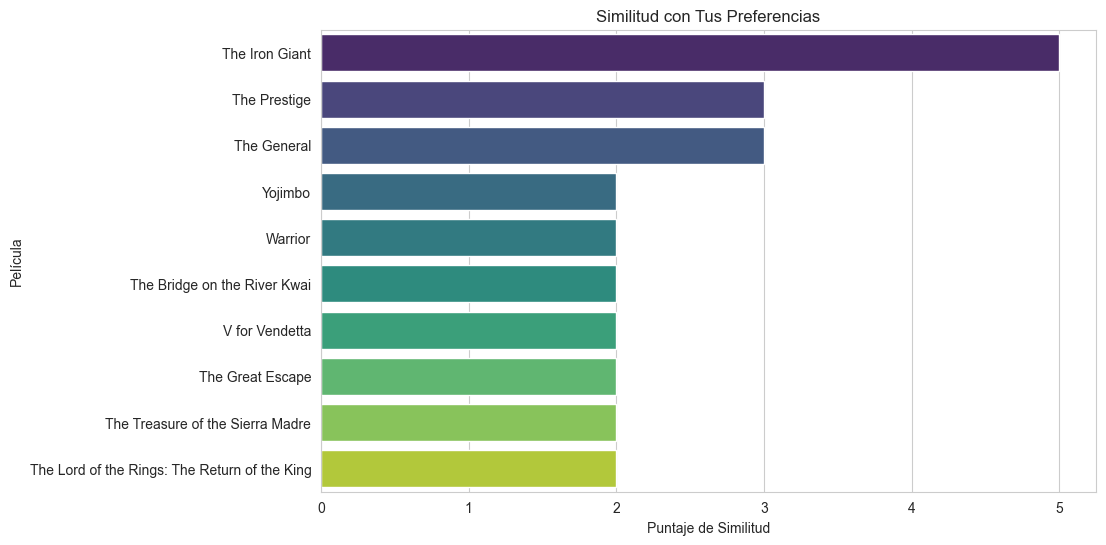

In [20]:
def mostrar_recomendaciones(df):
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='similarity_score',  # Columna correcta
        y='title',
        data=df.sort_values('similarity_score', ascending=False),
        palette='viridis'
    )
    plt.title('Similitud con Tus Preferencias')
    plt.xlabel('Puntaje de Similitud')
    plt.ylabel('Película')
    plt.show()

# Para hybrid_recommendations
recommendations = recommend_based_on_genres_and_directors(imdb_enriched, user_prefs, rated_movies)
mostrar_recomendaciones(recommendations)  # Usando la función actualizada